<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/selfattention2_50epoch_flower_D_sa_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#パッケージのダウンロード


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import argparse

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torchvision.transforms as transforms

In [ ]:
import torchvision.datasets as dset

In [ ]:
import torchvision.utils as vutils

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [ ]:
import glob

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
from torch.utils.data import DataLoader
import torchvision

In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 10.1 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 98.3MB/s]


In [ ]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [ ]:
#ハイパーパラメータの設定

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=64, nch_d=64, z_dim=100, beta1=0.5)


In [ ]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [ ]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [ ]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [ ]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
#モデルの設定

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [ ]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [ ]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [ ]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [ ]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [ ]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [ ]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [ ]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [ ]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf , attention = True)
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf, attention = True )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf, attention = True)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [ ]:
#モデルのトレーニング

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda')

In [ ]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [ ]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:03<00:00,  1.63it/s]


epoch: 0, lossD:1.3059045268240774, lossG:20.80532314707932,lossG_fake:15.10087583597424, lossG_real:5.70444730618625 ,equality:9.39642852978799


evaluate:218.75518798828125,kid_mean:0.18426117300987244, kid_std:0.026013853028416634,kid_:(tensor(0.1843), tensor(0.0260))


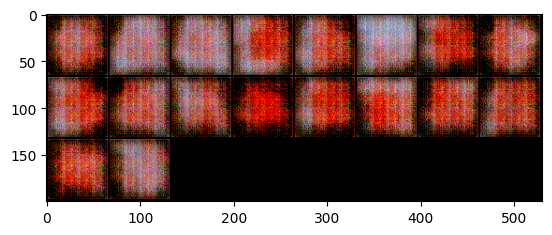

100%|██████████| 103/103 [00:09<00:00, 11.03it/s]


epoch: 1, lossD:0.6673455852653506, lossG:9.659678422131584,lossG_fake:5.608152287098968, lossG_real:4.0515261089917525 ,equality:1.5566261781072157


evaluate:150.69332885742188,kid_mean:0.10816679894924164, kid_std:0.03919408470392227,kid_:(tensor(0.1082), tensor(0.0392))


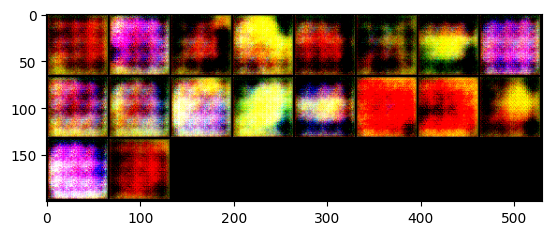

100%|██████████| 103/103 [00:09<00:00, 10.88it/s]


epoch: 2, lossD:1.143743282382928, lossG:6.552872685552801,lossG_fake:3.77714043450587, lossG_real:2.775732241209271 ,equality:1.0014081932965992


evaluate:138.12789916992188,kid_mean:0.08924368023872375, kid_std:0.03455245867371559,kid_:(tensor(0.0892), tensor(0.0346))


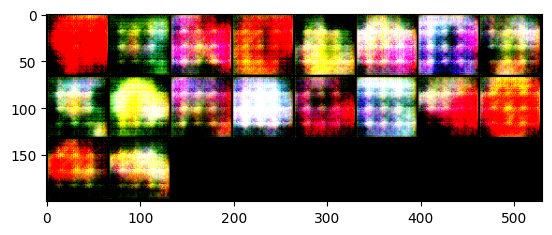

100%|██████████| 103/103 [00:09<00:00, 10.82it/s]


epoch: 3, lossD:1.002294768913857, lossG:7.3189579306296935,lossG_fake:4.3674778695245395, lossG_real:2.951480060237125 ,equality:1.4159978092874144


evaluate:145.34852600097656,kid_mean:0.10171787440776825, kid_std:0.04004839062690735,kid_:(tensor(0.1017), tensor(0.0400))


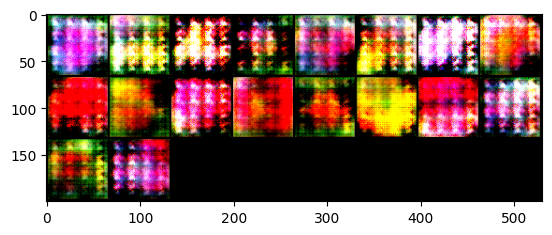

100%|██████████| 103/103 [00:09<00:00, 10.80it/s]


epoch: 4, lossD:1.1419718709674853, lossG:6.793530556762103,lossG_fake:4.0706666927893185, lossG_real:2.7228638714957007 ,equality:1.3478028212936177


evaluate:141.68138122558594,kid_mean:0.10595479607582092, kid_std:0.04974369704723358,kid_:(tensor(0.1060), tensor(0.0497))


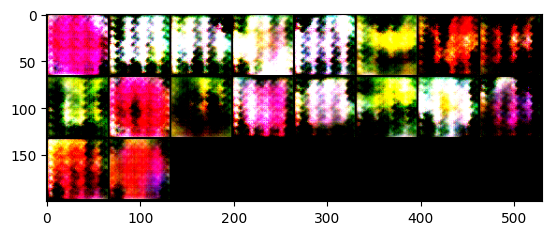

100%|██████████| 103/103 [00:09<00:00, 10.73it/s]


epoch: 5, lossD:1.0397348072633004, lossG:6.775106893002408,lossG_fake:3.9192903799918093, lossG_real:2.8558165263203743 ,equality:1.063473853671435


evaluate:134.28305053710938,kid_mean:0.08950239419937134, kid_std:0.04230981320142746,kid_:(tensor(0.0895), tensor(0.0423))


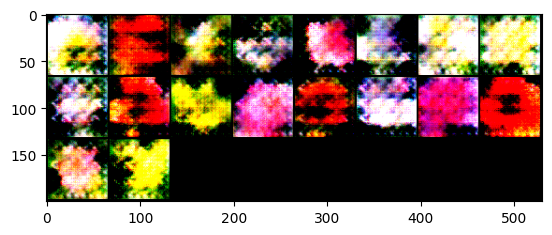

100%|██████████| 103/103 [00:09<00:00, 10.61it/s]


epoch: 6, lossD:1.007840284010739, lossG:6.57614711650367,lossG_fake:3.912884572177257, lossG_real:2.663262535067438 ,equality:1.2496220371098192


evaluate:133.25526428222656,kid_mean:0.09190797805786133, kid_std:0.03964883089065552,kid_:(tensor(0.0919), tensor(0.0396))


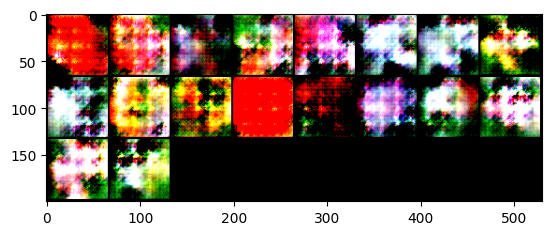

100%|██████████| 103/103 [00:09<00:00, 10.58it/s]


epoch: 7, lossD:0.8809505003748588, lossG:6.651922508350854,lossG_fake:3.8742993063139686, lossG_real:2.777623190752511 ,equality:1.0966761155614577


evaluate:130.76998901367188,kid_mean:0.08289072662591934, kid_std:0.039379313588142395,kid_:(tensor(0.0829), tensor(0.0394))


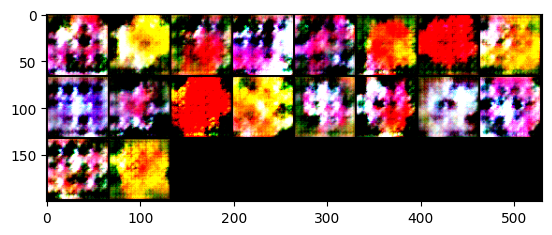

100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


epoch: 8, lossD:0.9152583844453386, lossG:6.740727711649774,lossG_fake:3.9371070121098493, lossG_real:2.8036206989612396 ,equality:1.1334863131486097


evaluate:134.0948486328125,kid_mean:0.08020279556512833, kid_std:0.0392899364233017,kid_:(tensor(0.0802), tensor(0.0393))


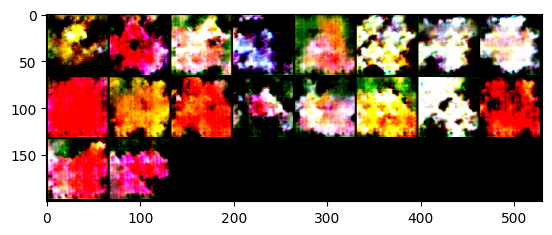

100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


epoch: 9, lossD:0.971469994308879, lossG:6.68546230353198,lossG_fake:3.913688085611584, lossG_real:2.7717742211031684 ,equality:1.1419138645084157


evaluate:134.42474365234375,kid_mean:0.08071354031562805, kid_std:0.04649655893445015,kid_:(tensor(0.0807), tensor(0.0465))


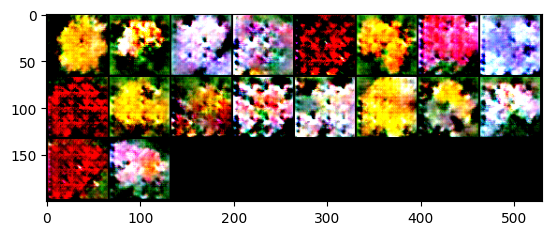

100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


epoch: 10, lossD:0.958717297581793, lossG:6.485689292833643,lossG_fake:3.683585867141057, lossG_real:2.802103431479445 ,equality:0.8814824356616122


evaluate:141.77694702148438,kid_mean:0.0981871709227562, kid_std:0.045783866196870804,kid_:(tensor(0.0982), tensor(0.0458))


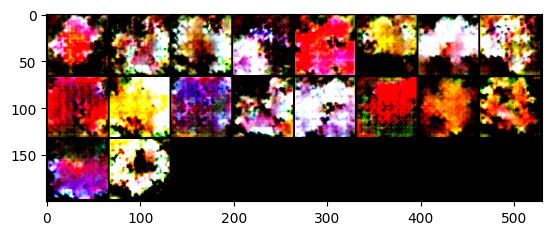

100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


epoch: 11, lossD:1.0812542066701407, lossG:6.567526724732038,lossG_fake:3.7692482818677586, lossG_real:2.7982784463363943 ,equality:0.9709698355313643


evaluate:141.0756378173828,kid_mean:0.09267663955688477, kid_std:0.04950299113988876,kid_:(tensor(0.0927), tensor(0.0495))


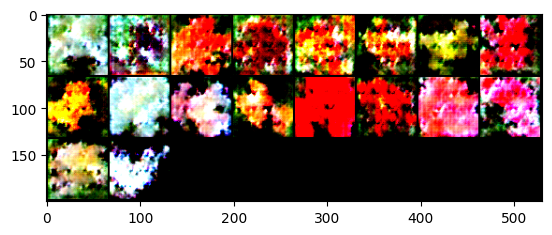

100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


epoch: 12, lossD:1.0103309539336602, lossG:6.5920387332879224,lossG_fake:3.7254298728646584, lossG_real:2.866608873733039 ,equality:0.8588209991316194


evaluate:130.22952270507812,kid_mean:0.09130817651748657, kid_std:0.047704074531793594,kid_:(tensor(0.0913), tensor(0.0477))


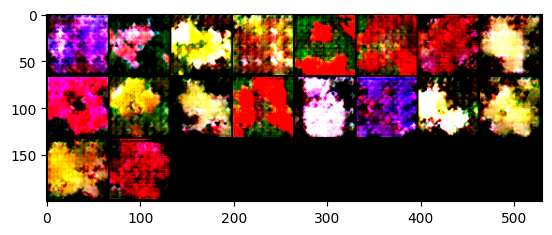

100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


epoch: 13, lossD:0.9762638410896931, lossG:6.500701594121248,lossG_fake:3.5938284964237397, lossG_real:2.9068731092712254 ,equality:0.6869553871525143


evaluate:126.20655822753906,kid_mean:0.08504227548837662, kid_std:0.04470621421933174,kid_:(tensor(0.0850), tensor(0.0447))


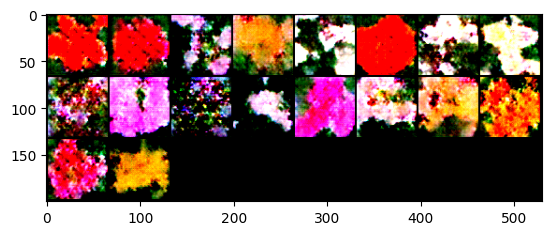

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 14, lossD:0.9357254063909494, lossG:6.704177087950475,lossG_fake:3.689777914760182, lossG_real:3.0143991775304366 ,equality:0.6753787372297455


evaluate:127.85637664794922,kid_mean:0.08520494401454926, kid_std:0.048601724207401276,kid_:(tensor(0.0852), tensor(0.0486))


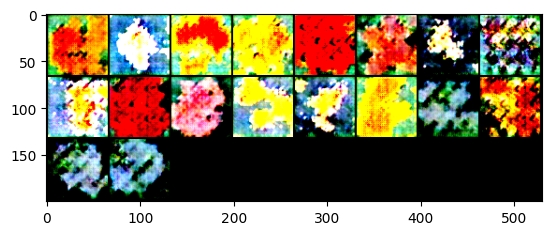

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 15, lossD:0.7761793592311803, lossG:6.7730517017031175,lossG_fake:3.752185813431601, lossG_real:3.0208658813272864 ,equality:0.7313199321043147


evaluate:122.4685287475586,kid_mean:0.10032357275485992, kid_std:0.049123190343379974,kid_:(tensor(0.1003), tensor(0.0491))


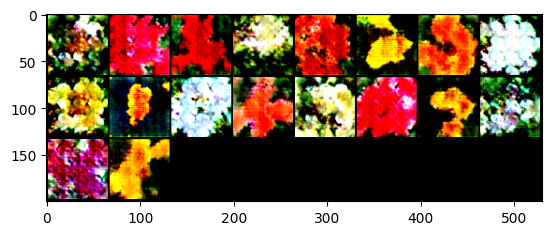

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 16, lossD:0.7066700756549835, lossG:7.062687503481374,lossG_fake:3.8612788140195087, lossG_real:3.20140869582741 ,equality:0.6598701181920985


evaluate:121.84239959716797,kid_mean:0.08837651461362839, kid_std:0.04546765238046646,kid_:(tensor(0.0884), tensor(0.0455))


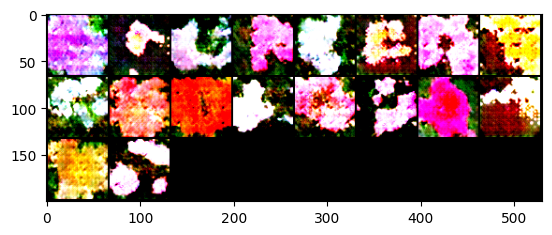

100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


epoch: 17, lossD:0.6291163054846444, lossG:7.246448558511086,lossG_fake:3.911181433686932, lossG_real:3.3352671248241537 ,equality:0.5759143088627785


evaluate:123.01802062988281,kid_mean:0.09445634484291077, kid_std:0.048258665949106216,kid_:(tensor(0.0945), tensor(0.0483))


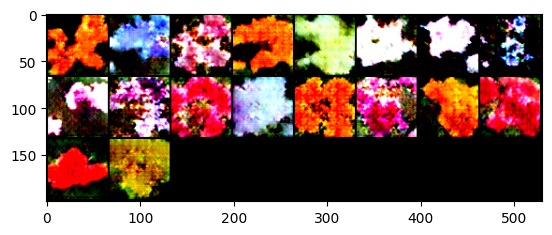

100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


epoch: 18, lossD:0.6790848498060865, lossG:7.322482132217259,lossG_fake:3.9081296515696256, lossG_real:3.4143524806476333 ,equality:0.49377717092199225


evaluate:124.57608795166016,kid_mean:0.08652032166719437, kid_std:0.04556119441986084,kid_:(tensor(0.0865), tensor(0.0456))


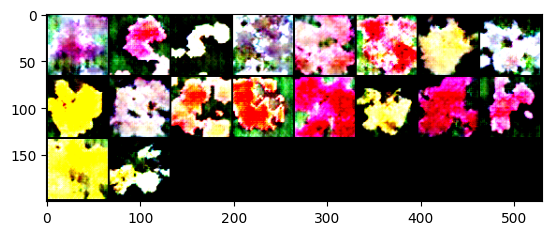

100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


epoch: 19, lossD:0.5472225786268132, lossG:7.794726904156138,lossG_fake:4.251560171831001, lossG_real:3.5431667543152003 ,equality:0.7083934175158011


evaluate:125.19928741455078,kid_mean:0.08490658551454544, kid_std:0.04360528662800789,kid_:(tensor(0.0849), tensor(0.0436))


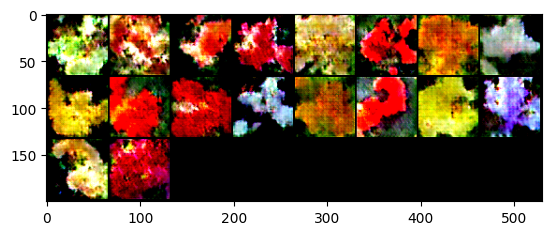

100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


epoch: 20, lossD:0.43366415404434344, lossG:8.111069980176907,lossG_fake:4.432742946356246, lossG_real:3.6783270916892485 ,equality:0.7544158546669975


evaluate:126.48731994628906,kid_mean:0.0984354242682457, kid_std:0.05187813192605972,kid_:(tensor(0.0984), tensor(0.0519))


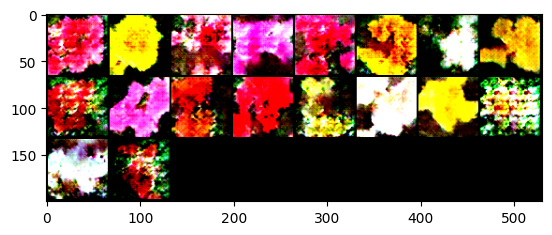

100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


epoch: 21, lossD:0.42795641879433566, lossG:8.334208701420756,lossG_fake:4.492456612077731, lossG_real:3.84175209281514 ,equality:0.6507045192625913


evaluate:123.3462142944336,kid_mean:0.08530180901288986, kid_std:0.04402393102645874,kid_:(tensor(0.0853), tensor(0.0440))


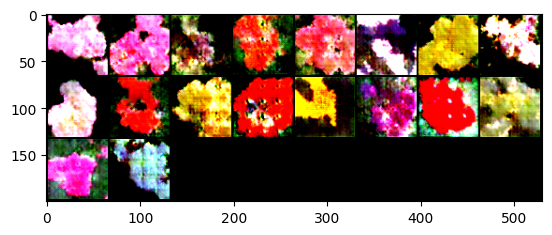

100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


epoch: 22, lossD:0.4409818426136253, lossG:8.504462501377736,lossG_fake:4.634274709571913, lossG_real:3.8701877999074252 ,equality:0.7640869096644876


evaluate:123.72216033935547,kid_mean:0.08737615495920181, kid_std:0.04807085916399956,kid_:(tensor(0.0874), tensor(0.0481))


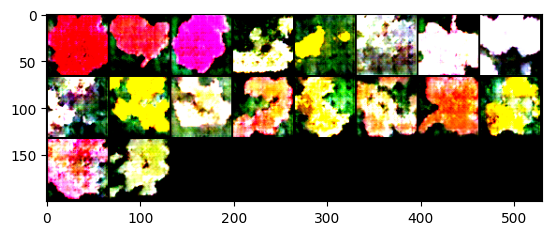

100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


epoch: 23, lossD:0.48203487800958666, lossG:8.350074693994614,lossG_fake:4.429359027482931, lossG_real:3.9207157162786688 ,equality:0.5086433112042625


evaluate:121.40641784667969,kid_mean:0.09582594037055969, kid_std:0.04777683690190315,kid_:(tensor(0.0958), tensor(0.0478))


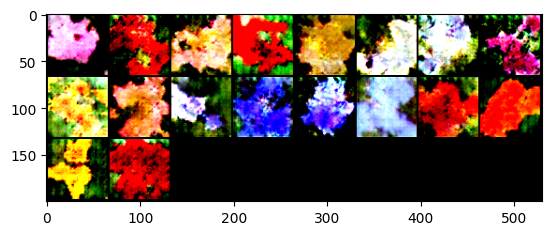

100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


epoch: 24, lossD:0.4381024401851939, lossG:8.802607999264616,lossG_fake:4.7521973709458285, lossG_real:4.050410624846672 ,equality:0.7017867460991569


evaluate:121.27455139160156,kid_mean:0.0878552719950676, kid_std:0.04417381435632706,kid_:(tensor(0.0879), tensor(0.0442))


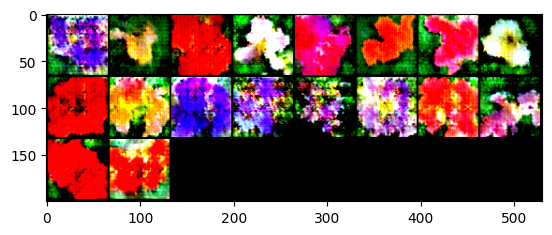

100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


epoch: 25, lossD:0.34412724224543106, lossG:8.600900937052605,lossG_fake:4.5653298121054195, lossG_real:4.035571107586611 ,equality:0.5297587045188088


evaluate:119.92102813720703,kid_mean:0.08844590187072754, kid_std:0.05209891498088837,kid_:(tensor(0.0884), tensor(0.0521))


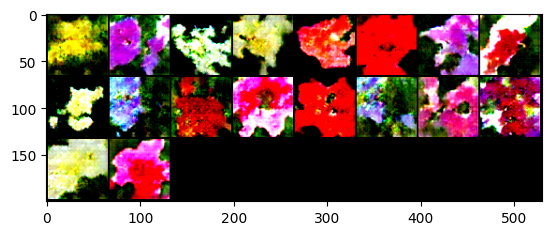

100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


epoch: 26, lossD:0.37077863002648054, lossG:9.171561801317827,lossG_fake:4.991340095557056, lossG_real:4.1802217086542 ,equality:0.811118386902856


evaluate:117.34603881835938,kid_mean:0.08362125605344772, kid_std:0.04289529472589493,kid_:(tensor(0.0836), tensor(0.0429))


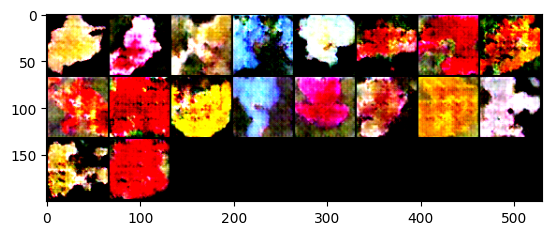

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 27, lossD:0.32304644694967755, lossG:8.949636033437784,lossG_fake:4.8673356551568485, lossG_real:4.0823003898546535 ,equality:0.785035265302195


evaluate:118.05863952636719,kid_mean:0.08404462784528732, kid_std:0.03986002504825592,kid_:(tensor(0.0840), tensor(0.0399))


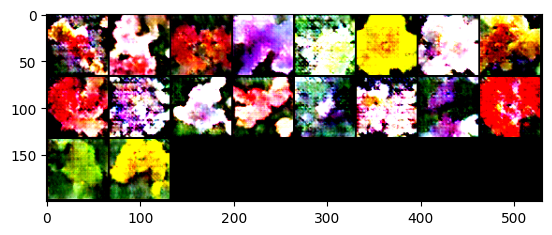

100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


epoch: 28, lossD:0.33132390824408786, lossG:9.065418303591533,lossG_fake:4.855762221280811, lossG_real:4.209656064660804 ,equality:0.6461061566200073


evaluate:119.5357894897461,kid_mean:0.08952562510967255, kid_std:0.04260451719164848,kid_:(tensor(0.0895), tensor(0.0426))


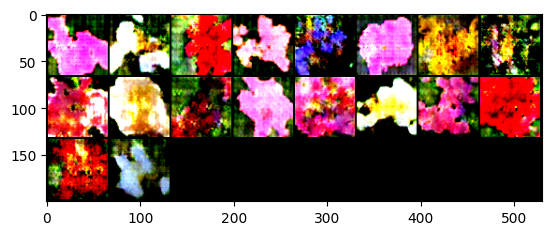

100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


epoch: 29, lossD:0.3010262513659822, lossG:9.12047013958681,lossG_fake:4.857105410214767, lossG_real:4.263364717219639 ,equality:0.5937406929951274


evaluate:119.21072387695312,kid_mean:0.09223665297031403, kid_std:0.04466112703084946,kid_:(tensor(0.0922), tensor(0.0447))


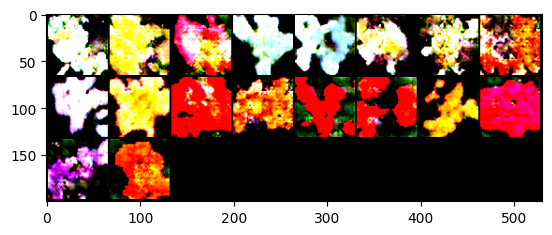

100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


epoch: 30, lossD:0.2676518370297927, lossG:9.306981054324549,lossG_fake:4.904090359373, lossG_real:4.40289070305315 ,equality:0.5011996563198498


evaluate:119.2092056274414,kid_mean:0.07568700611591339, kid_std:0.0404653325676918,kid_:(tensor(0.0757), tensor(0.0405))


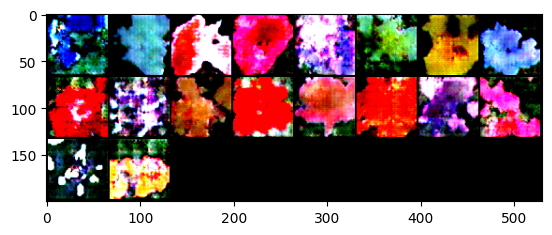

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 31, lossD:0.31349620170601944, lossG:9.59188632594729,lossG_fake:5.139663602541951, lossG_real:4.452222705176733 ,equality:0.6874408973652182


evaluate:118.81651306152344,kid_mean:0.09128857403993607, kid_std:0.046925563365221024,kid_:(tensor(0.0913), tensor(0.0469))


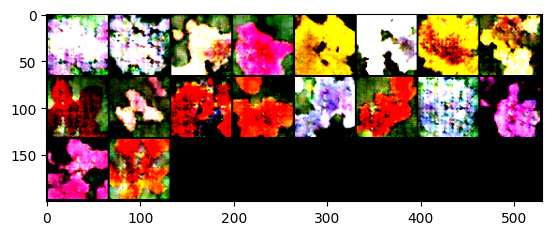

100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


epoch: 32, lossD:0.3361735402163371, lossG:9.648914198273594,lossG_fake:5.045577956634817, lossG_real:4.603336246268263 ,equality:0.44224171036655413


evaluate:117.66983032226562,kid_mean:0.08658352494239807, kid_std:0.042206209152936935,kid_:(tensor(0.0866), tensor(0.0422))


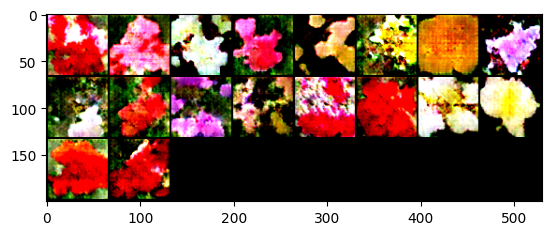

100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


epoch: 33, lossD:0.25942128940114695, lossG:9.559775519139558,lossG_fake:5.041344313945585, lossG_real:4.518431185518653 ,equality:0.5229131284269313


evaluate:117.18377685546875,kid_mean:0.08943036198616028, kid_std:0.043545808643102646,kid_:(tensor(0.0894), tensor(0.0435))


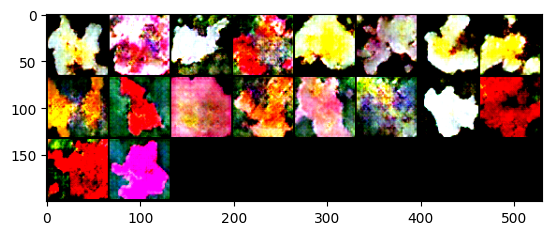

100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


epoch: 34, lossD:0.3126012078368837, lossG:9.793365047973337,lossG_fake:5.173781316257218, lossG_real:4.619583682238477 ,equality:0.5541976340187409


evaluate:115.76741027832031,kid_mean:0.08340886980295181, kid_std:0.05047185719013214,kid_:(tensor(0.0834), tensor(0.0505))


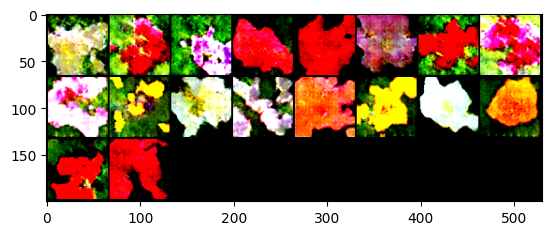

100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


epoch: 35, lossD:0.30204410424220907, lossG:9.373976925044383,lossG_fake:4.936180604314341, lossG_real:4.437796270963058 ,equality:0.4983843333512832


evaluate:116.65829467773438,kid_mean:0.07972481101751328, kid_std:0.04361073300242424,kid_:(tensor(0.0797), tensor(0.0436))


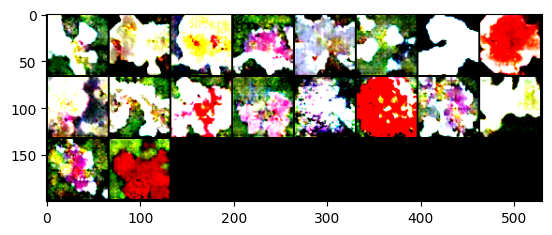

100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


epoch: 36, lossD:0.26356123698857226, lossG:9.909953603466738,lossG_fake:5.1593776281597545, lossG_real:4.750576000769161 ,equality:0.4088016273905932


evaluate:113.5929183959961,kid_mean:0.09281498193740845, kid_std:0.04991627112030983,kid_:(tensor(0.0928), tensor(0.0499))


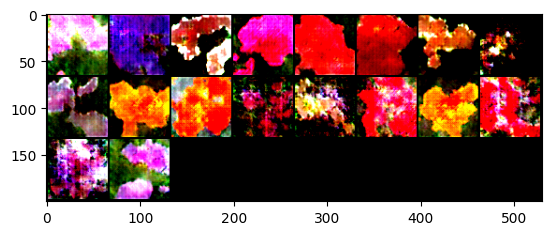

100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


epoch: 37, lossD:0.24972114746359367, lossG:10.22630831338827,lossG_fake:5.467226845546834, lossG_real:4.7590814661053775 ,equality:0.7081453794414561


evaluate:112.96782684326172,kid_mean:0.08257030695676804, kid_std:0.041616037487983704,kid_:(tensor(0.0826), tensor(0.0416))


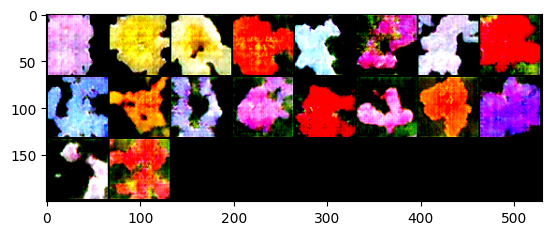

100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


epoch: 38, lossD:0.23044061541412642, lossG:10.344424969941667,lossG_fake:5.500675304422101, lossG_real:4.8437496794080275 ,equality:0.6569256250140736


evaluate:111.45416259765625,kid_mean:0.07514214515686035, kid_std:0.03885778412222862,kid_:(tensor(0.0751), tensor(0.0389))


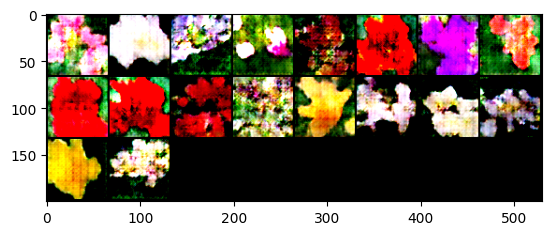

100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


epoch: 39, lossD:0.2128810402259086, lossG:10.51433732671645,lossG_fake:5.529408429432841, lossG_real:4.984928897283609 ,equality:0.5444795321492322


evaluate:112.81035614013672,kid_mean:0.08179344236850739, kid_std:0.04234408587217331,kid_:(tensor(0.0818), tensor(0.0423))


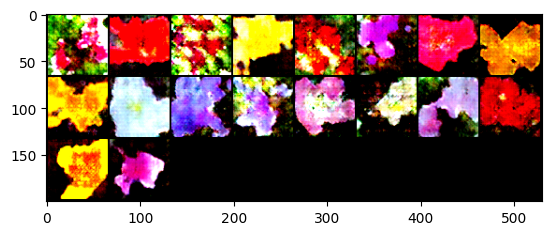

100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


epoch: 40, lossD:0.275419822830743, lossG:10.433838483199333,lossG_fake:5.585947404787379, lossG_real:4.847891037903943 ,equality:0.7380563668834359


evaluate:112.78665161132812,kid_mean:0.08134332299232483, kid_std:0.03824726119637489,kid_:(tensor(0.0813), tensor(0.0382))


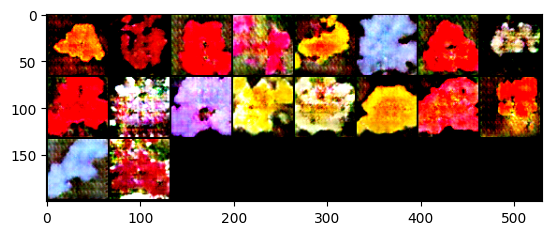

100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


epoch: 41, lossD:0.2616383506581911, lossG:10.510636875930341,lossG_fake:5.530065460112488, lossG_real:4.9805714318763865 ,equality:0.5494940282361016


evaluate:113.54148864746094,kid_mean:0.07974880188703537, kid_std:0.04224105179309845,kid_:(tensor(0.0797), tensor(0.0422))


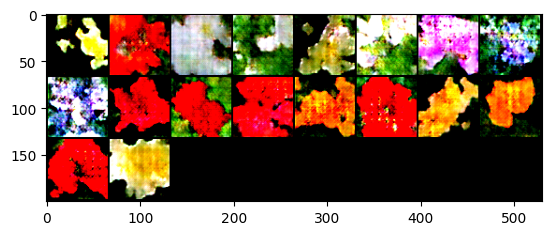

100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


epoch: 42, lossD:0.19590464717193137, lossG:10.657491461744586,lossG_fake:5.753107165827335, lossG_real:4.904384295917252 ,equality:0.848722869910083


evaluate:112.8586654663086,kid_mean:0.0802365392446518, kid_std:0.04365577921271324,kid_:(tensor(0.0802), tensor(0.0437))


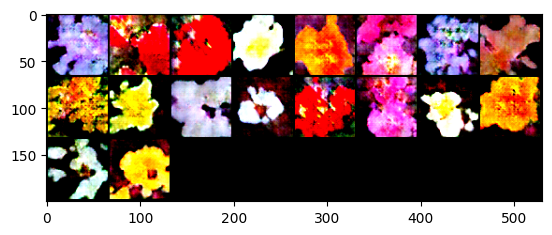

100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


epoch: 43, lossD:0.2562860851221293, lossG:10.780689295055797,lossG_fake:5.685897119994302, lossG_real:5.094792234087453 ,equality:0.5911048859068488


evaluate:113.18159484863281,kid_mean:0.0839969664812088, kid_std:0.0411316342651844,kid_:(tensor(0.0840), tensor(0.0411))


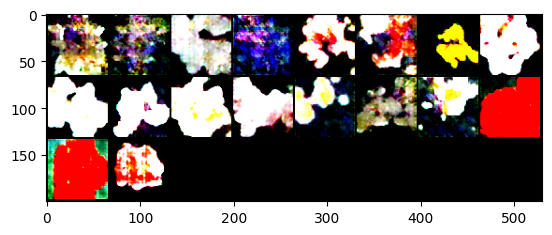

100%|██████████| 103/103 [00:10<00:00, 10.18it/s]


epoch: 44, lossD:0.13682236397657002, lossG:10.776591837984844,lossG_fake:5.774060760886924, lossG_real:5.0025311210780465 ,equality:0.7715296398088771


evaluate:113.11023712158203,kid_mean:0.07956897467374802, kid_std:0.039698343724012375,kid_:(tensor(0.0796), tensor(0.0397))


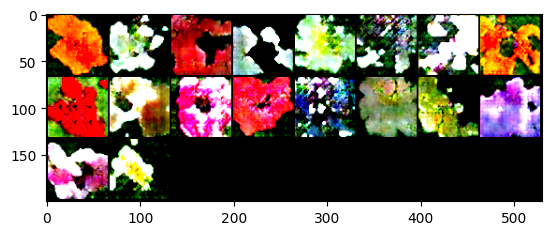

100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


epoch: 45, lossD:0.31456311305677426, lossG:11.044533711035275,lossG_fake:5.826469068388337, lossG_real:5.218064627601105 ,equality:0.6084044407872318


evaluate:114.14949798583984,kid_mean:0.08053237944841385, kid_std:0.0411841906607151,kid_:(tensor(0.0805), tensor(0.0412))


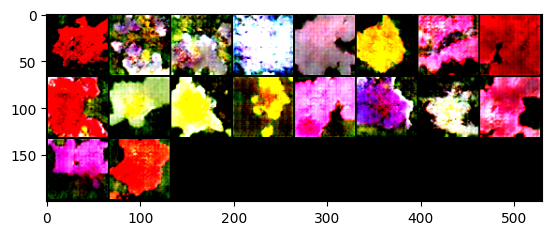

100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


epoch: 46, lossD:0.13684767647420318, lossG:10.723633219894854,lossG_fake:5.581774792624909, lossG_real:5.141858420325715 ,equality:0.43991637229919434


evaluate:115.14727020263672,kid_mean:0.08350314199924469, kid_std:0.04624392092227936,kid_:(tensor(0.0835), tensor(0.0462))


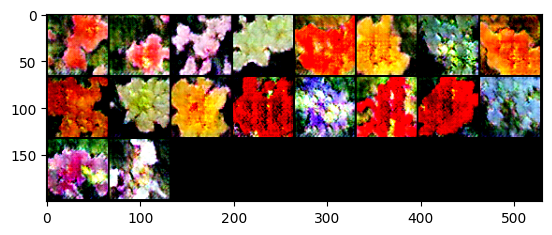

100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


epoch: 47, lossD:0.23615885945489107, lossG:11.390996988537243,lossG_fake:6.256985444467045, lossG_real:5.134011548699685 ,equality:1.1229738957673598


evaluate:115.66112518310547,kid_mean:0.08971904963254929, kid_std:0.046308524906635284,kid_:(tensor(0.0897), tensor(0.0463))


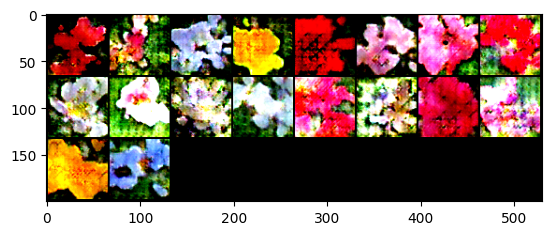

100%|██████████| 103/103 [00:10<00:00, 10.12it/s]


epoch: 48, lossD:0.18440511826317288, lossG:11.145533728368074,lossG_fake:5.80528041691456, lossG_real:5.340253320712487 ,equality:0.46502709620207305


evaluate:115.79544830322266,kid_mean:0.08270051330327988, kid_std:0.038099028170108795,kid_:(tensor(0.0827), tensor(0.0381))


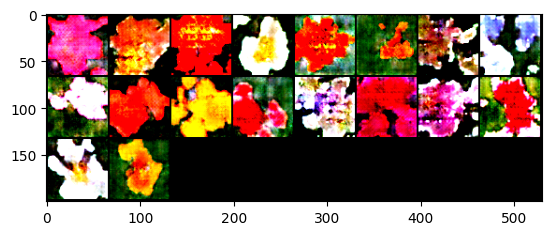

100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


epoch: 49, lossD:0.19472616560106137, lossG:11.30884443671958,lossG_fake:5.859439583658014, lossG_real:5.449404831650187 ,equality:0.41003475200782713


evaluate:115.90483856201172,kid_mean:0.08123009651899338, kid_std:0.05310884118080139,kid_:(tensor(0.0812), tensor(0.0531))


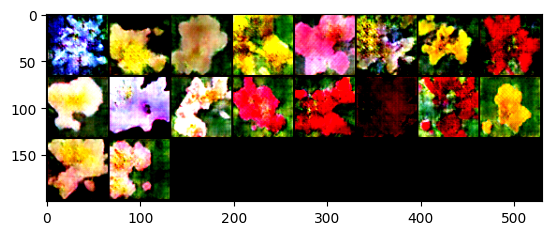

In [ ]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

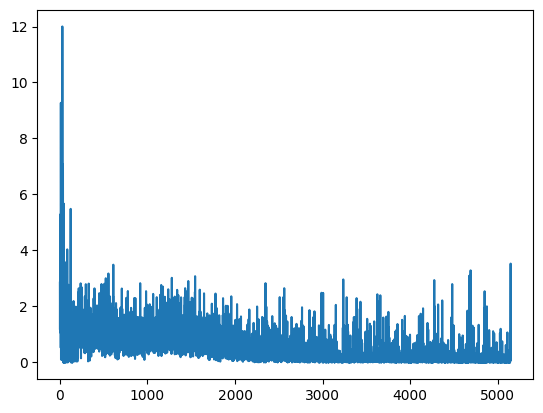

In [ ]:
plt.plot(raw_lossesD)

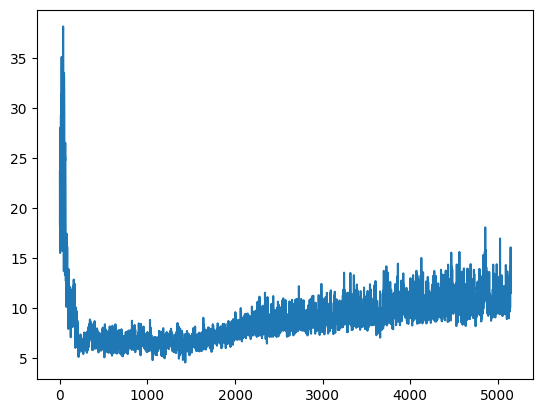

In [ ]:
plt.plot(raw_lossesG)

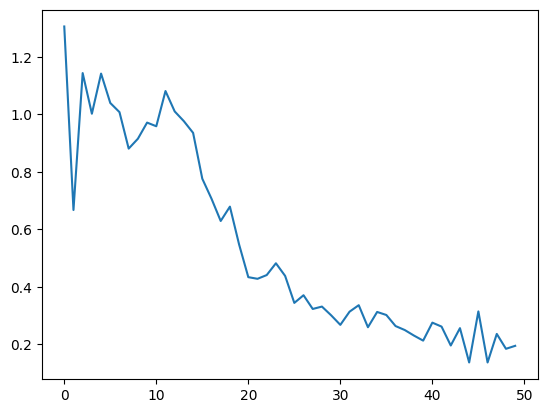

In [ ]:
plt.plot(lossesD)

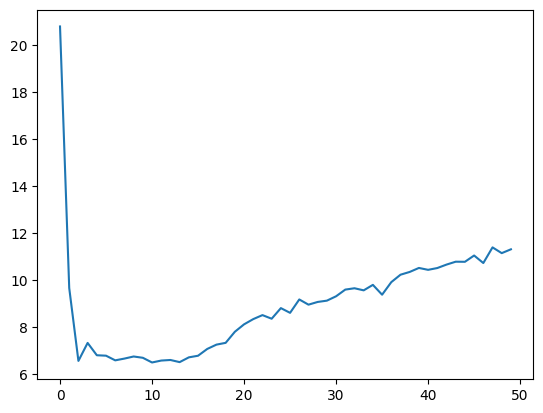

In [ ]:
plt.plot(lossesG)

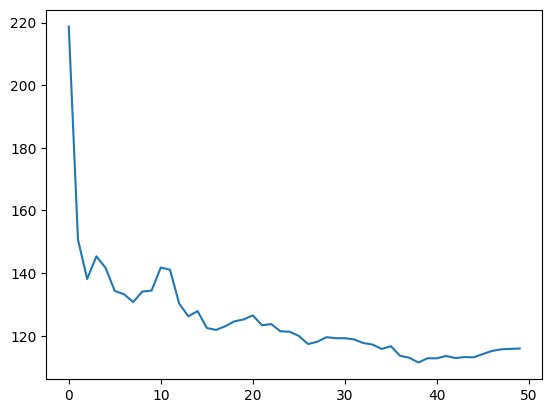

In [ ]:
plt.plot(fid_)

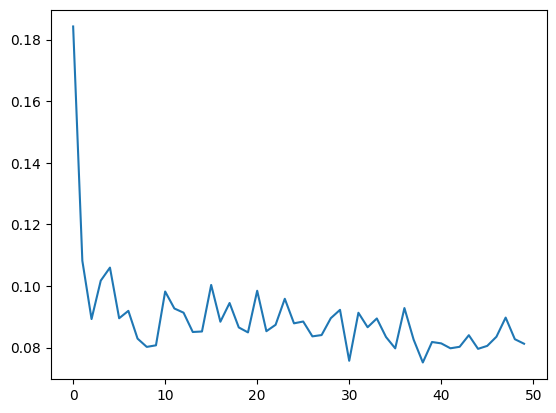

In [ ]:
plt.plot(kid_mean_)

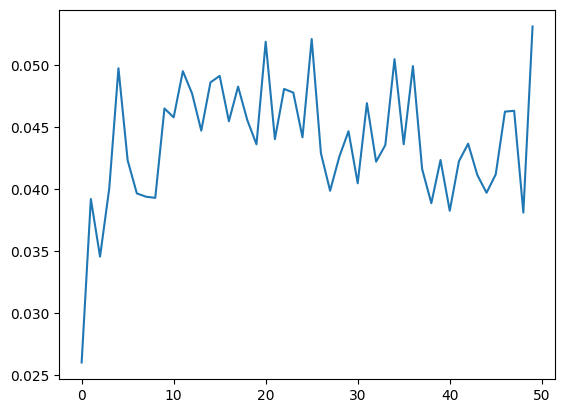

In [ ]:
plt.plot(kid_std_)

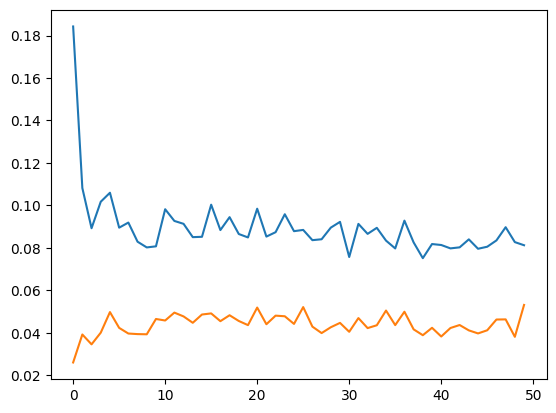

In [ ]:
plt.plot(kid_score)

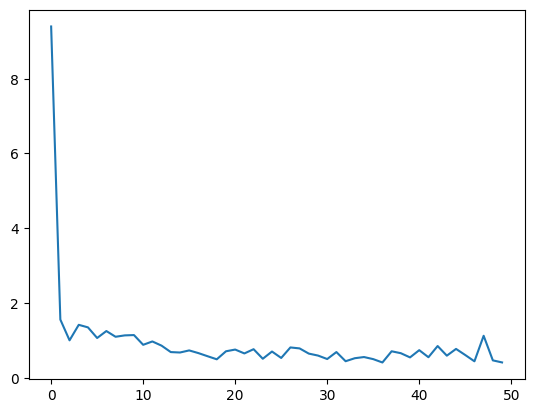

In [ ]:
plt.plot(d_equality)

In [ ]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0809), tensor(0.0371))